In [1]:
import scipy.io
import pathlib
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# useful variables
data_root = './images/'
img_width = 150
img_height = 80
embedding_dim = 128
units = 128
batch_size = 20

In [3]:
df_label = pd.read_csv('./label.csv', header=None)
df_label[1] = df_label[1].apply(lambda x: '%04d'.ljust(4) % x)
df_train, df_valid = train_test_split(df_label, test_size=0.2, random_state=0)

In [4]:
len(df_train), len(df_valid)

(8000, 2000)

In [15]:
# characters = set(char for label in df_label[1] for char in label)
# char_to_num = layers.StringLookup(
#     vocabulary=list(characters), mask_token=None
# )
# num_to_char = layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

In [5]:
num_to_char.get_vocabulary()

['[UNK]', '6', '5', '1', '8', '2', '7', '9', '3', '4', '0']

In [6]:
def load_image(img_path, label):
    # 1. Read image
    img = tf.io.read_file(data_root+img_path+'.png')
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((df_train[0], df_train[1]))
train_dataset = (
    train_dataset.map(
        load_image, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_dataset = tf.data.Dataset.from_tensor_slices((df_valid[0], df_valid[1]))
validation_dataset = (
    validation_dataset.map(
        load_image, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

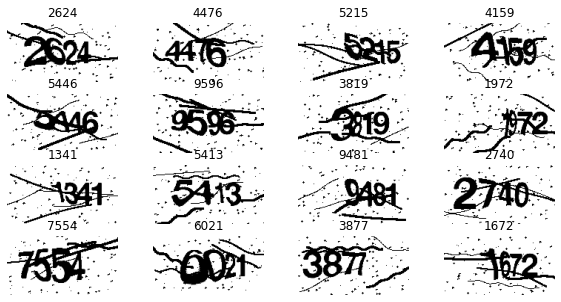

In [186]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('utf-8')
#         label = labels[i].numpy()
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [187]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()

In [188]:
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 150, 80, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 80, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 75, 40, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 75, 40, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [189]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
400/400 [==============================] - 18s 39ms/step - loss: 11.1471 - val_loss: 10.7801
Epoch 2/100
400/400 [==============================] - 14s 34ms/step - loss: 10.6334 - val_loss: 10.5761
Epoch 3/100
400/400 [==============================] - 13s 34ms/step - loss: 10.5233 - val_loss: 10.4828
Epoch 4/100
400/400 [==============================] - 14s 34ms/step - loss: 10.4741 - val_loss: 10.4029
Epoch 5/100
400/400 [==============================] - 14s 34ms/step - loss: 10.3849 - val_loss: 10.2738
Epoch 6/100
400/400 [==============================] - 13s 34ms/step - loss: 10.2711 - val_loss: 10.2324
Epoch 7/100
400/400 [==============================] - 14s 34ms/step - loss: 10.2523 - val_loss: 10.1930
Epoch 8/100
400/400 [==============================] - 13s 34ms/step - loss: 10.1486 - val_loss: 10.0563
Epoch 9/100
400/400 [==============================] - 14s 34ms/step - loss: 10.1018 - val_loss: 10.0527
Epoch 10/100
400/400 [==============================] -

In [16]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    
    # Construct look table by list, because I forgot to store it
    characters = ['[UNK]', '4', '5', '0', '6', '3', '7', '9', '1', '8', '2']
    num_to_char = layers.StringLookup(
        vocabulary=characters, mask_token=None, invert=True
    )
    
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :4 # max length = 4
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

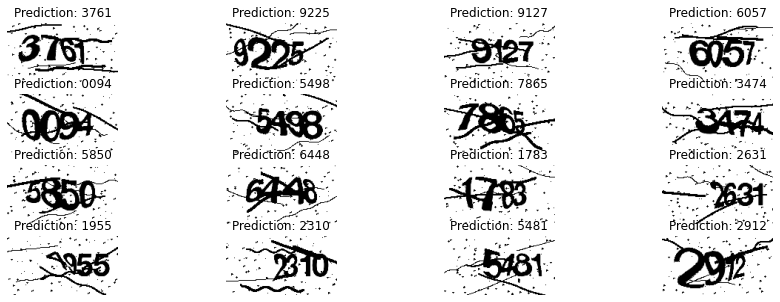

In [201]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [10]:
prediction_model = models.load_model('./prediction_model.h5', compile=False)

In [18]:
pred = []
true = df_valid[1].to_list()

for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred += pred_texts

accuracy_score(true, pred)

0.9335

In [21]:
df_valid['pred'] = pred

In [72]:
df_valid.columns

Index([0, 1, 'pred', 'equal'], dtype='object')

In [71]:
comparison_column = np.where(df_valid[1] == df_valid["pred"], 1, 0)
df_valid["equal"] = comparison_column

In [56]:
wrong_list = []
for i, eq in enumerate(df_valid['equal']):
    if not eq:
        wrong_list.append(list(df_valid[0])[i])

In [64]:
df = pd.DataFrame(wrong_list, columns=['path'])
df.to_csv('./pred_wrong_img.csv')

In [73]:
df_valid.to_csv('./valid_report.csv')

In [203]:
# model.load('model.h5')
# prediction_model.save('prediction_model.h5')